<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Физтех-Школа-Прикладной-математики-и-информатики-(ФПМИ)-МФТИ-Путешествие-по-Спрингфилду." data-toc-modified-id="Физтех-Школа-Прикладной-математики-и-информатики-(ФПМИ)-МФТИ-Путешествие-по-Спрингфилду.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</strong> Путешествие по Спрингфилду.</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Установка-зависимостей" data-toc-modified-id="Установка-зависимостей-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Установка зависимостей</a></span></li><li><span><a href="#Построение-нейросети" data-toc-modified-id="Построение-нейросети-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Построение нейросети</a></span></li><li><span><a href="#Ну-и-что-теперь-со-всем-этим-делать?" data-toc-modified-id="Ну-и-что-теперь-со-всем-этим-делать?-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Ну и что теперь со всем этим делать?</a></span></li><li><span><a href="#Submit-на-Kaggle" data-toc-modified-id="Submit-на-Kaggle-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Submit на Kaggle</a></span></li></ul></li></ul></li><li><span><a href="#Своя-CNN" data-toc-modified-id="Своя-CNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Своя CNN</a></span></li><li><span><a href="#Feature-Extractor-//-VGG16" data-toc-modified-id="Feature-Extractor-//-VGG16-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Extractor // VGG16</a></span></li><li><span><a href="#Feature-Extractor-//-ResNet50" data-toc-modified-id="Feature-Extractor-//-ResNet50-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Extractor // ResNet50</a></span></li><li><span><a href="#Fine-Tuning-//-EfficientNet-//-Augmentation" data-toc-modified-id="Fine-Tuning-//-EfficientNet-//-Augmentation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fine Tuning // EfficientNet // Augmentation</a></span></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

<div class="alert alert-info"> <b>От автора:</b>
<br>
<br>Нашей <b>задачей</b> будет научиться классифицировать персонажей проживающих в Спрингфилде. <b>Целевая метрика F1-score не менее 0.83</b>
    <br>
<br>1. Выполнение работы происходило на локальном компьютере под OS Win10 на GPU (обучение на 40% происходило быстрее, чем на Colab).
<br>2. Непосредственно моя работа начинается с раздела 2. Функции использованы из предоставленного шаблона, за редким исключением (функция train и класс SimpsonsDataset немного изменены, подробнее в разделах 2 и 5).
<br>3. Полученные результаты сведены в таблицу в разделе 6.
<br>4. Лучший результат показала модель <b>EfficientNet (B2)</b>, все слои которой обучены на тренировном датасете (метод Fine Tuning), а также с добавлением аугментаций. <b>Результат на Kaggle = 0.99681<b>

</div>



# **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ** Путешествие по Спрингфилду.

Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [9]:
import pickle
import numpy as np
import pandas as pd
#from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torchvision import transforms,models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim as optim
from efficientnet_pytorch import EfficientNet

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

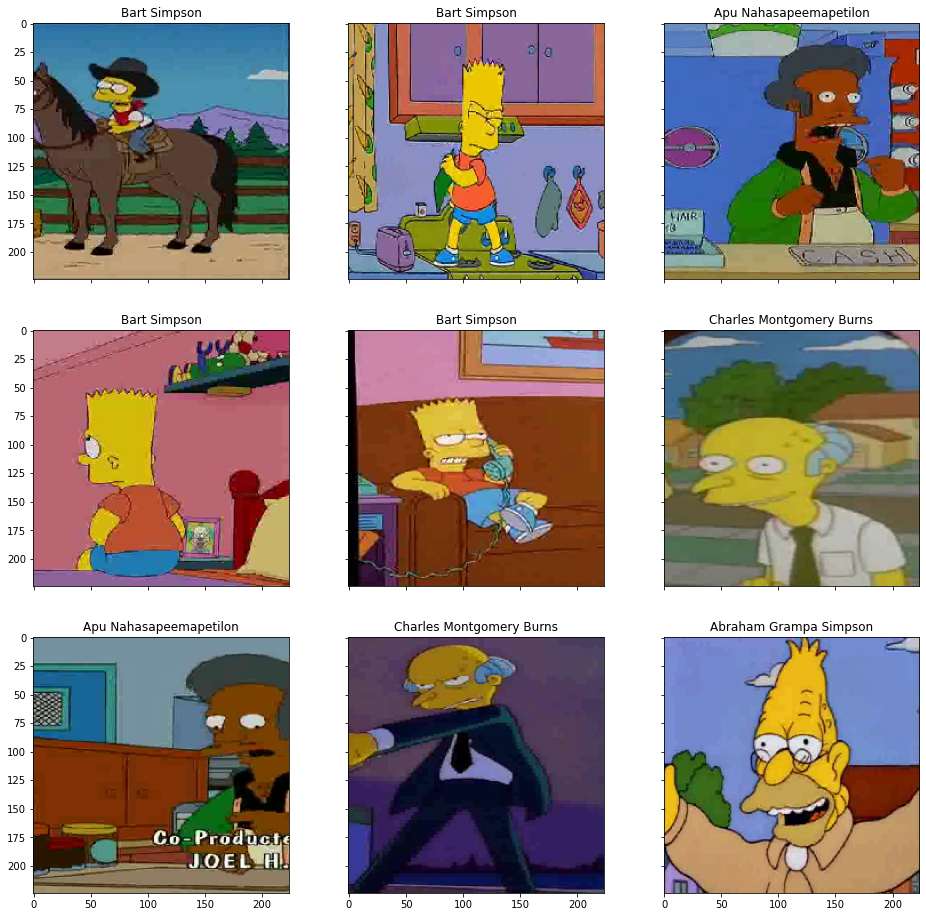

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [18]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [25]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

loss 2.4820481878047125


epoch:  50%|██████████████████████████████████████▌                                      | 1/2 [01:31<01:31, 91.05s/it]


Epoch 001 train_loss: 2.4820     val_loss 1.8426 train_acc 0.3063 val_acc 0.4985
loss 1.522044990410341


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [03:05<00:00, 92.71s/it]


Epoch 002 train_loss: 1.5220     val_loss 1.3024 train_acc 0.5849 val_acc 0.6400


Построим кривые обучения

In [26]:
loss, acc, val_loss, val_acc = zip(*history)

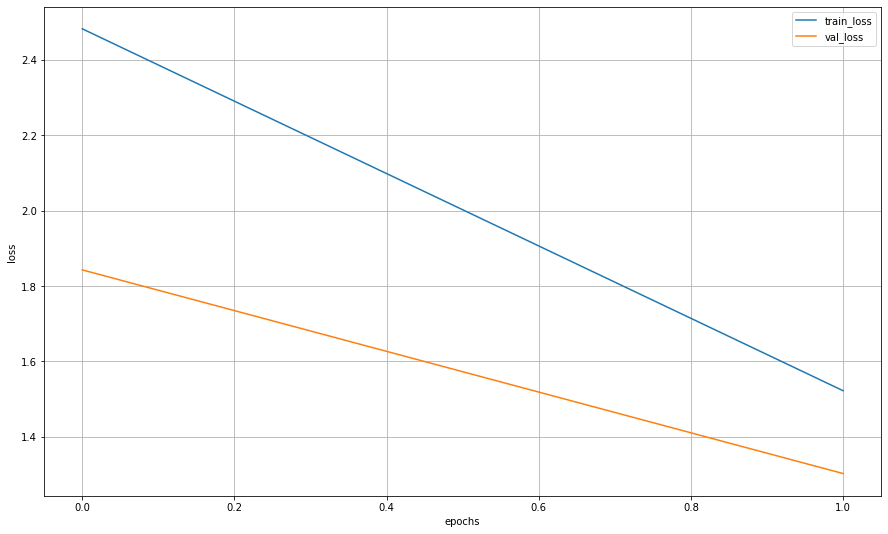

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [29]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [30]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [31]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [32]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [33]:
f1_score(actual_labels, y_pred, average='macro')

0.26545454545454544

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

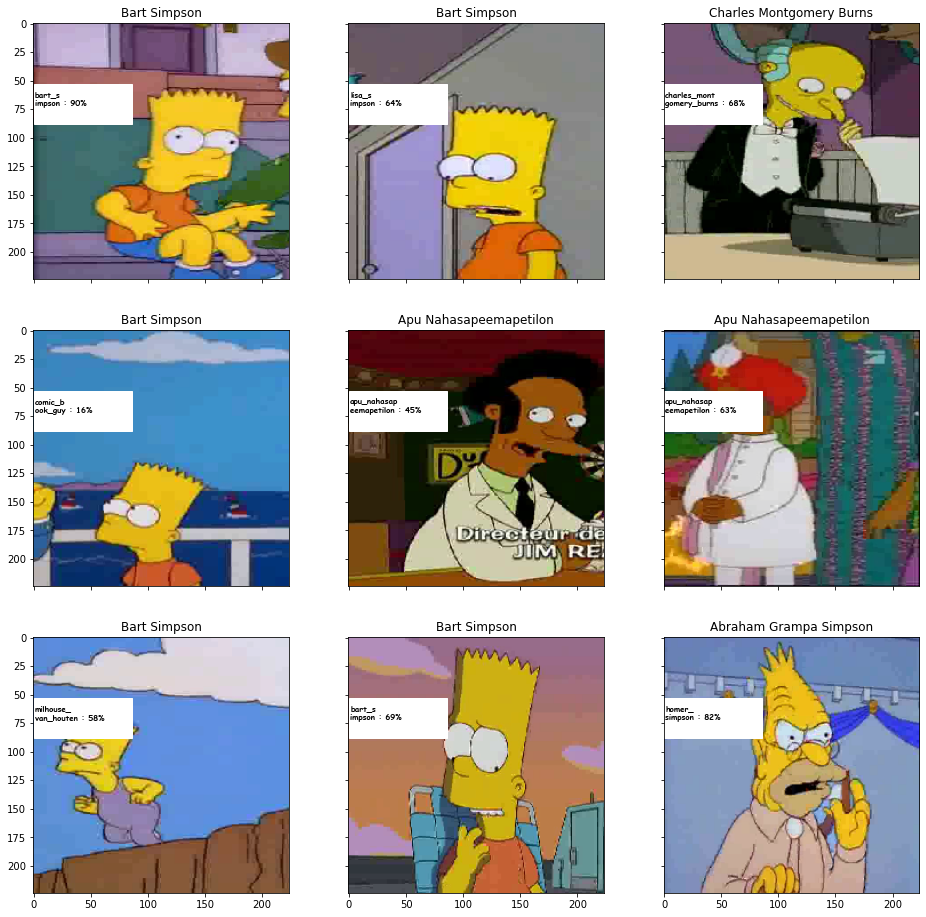

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [35]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [36]:
import pandas as pd
my_submit = pd.read_csv("./sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

Image_id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            lisa_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [38]:
my_submit.to_csv('simple_cnn.csv', index=False)

In [39]:
torch.cuda.empty_cache()

# Своя CNN

Чтобы добиться лучшего качества классификации необходимо использовать нейронные сети более сложной архитектуры. Добавим новые слои, батч-нормализацию, avg-пулинг и dropout. В качестве функции активации воспользуемся Elu.

In [40]:
class MyCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)     
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 12, 500)
        self.dropout = nn.Dropout(0.15)
        self.fc2 = nn.Linear(500, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, n_classes)
        

    def forward(self, x):    
        x = F.elu(self.conv1(x))
        x = self.pool(self.bn1(F.elu(self.conv2(x))))
        x = self.pool(self.bn1(F.elu(self.conv3(x))))
        x = self.flat(x)
        x = self.dropout(F.elu(self.fc1(x)))
        x = self.bn2(F.elu(self.fc2(x)))
        x = self.bn3(F.elu(self.fc3(x)))
        x = self.fc4(x)
        return x

Сеть имеет следующую архитектуру:

In [41]:
n_classes = len(np.unique(train_val_labels))
my_cnn = MyCNN(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn)

we will classify :42
MyCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=500, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=42, bias=True)
)


Изменим функцию обучения (`train`) - добавим ручную настройку используемого оптимизатора и шедулера. Также добавим фичу, позволяющую прерывать процесс обучения сети в случае, если в течении нескольких эпох лосс не уменьшается.

In [42]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, scheduler=None, over_train=None):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss =  np.inf
    over_train_cnt = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
                    
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if val_loss < best_val_loss:
                over_train_cnt = 0
                best_val_loss = val_loss
              
            if over_train is not None:
                if over_train_cnt > over_train:
                    break
            over_train_cnt += 1
          
    return history

In [43]:
# обучаем
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

history = train(train_dataset, val_dataset, model=my_cnn, epochs=10, batch_size=64,
                optimizer=optimizer, scheduler=scheduler)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 2.2825054528645037


epoch:  10%|███████▌                                                                    | 1/10 [01:35<14:23, 95.99s/it]


Epoch 001 train_loss: 2.2825     val_loss 2.0839 train_acc 0.4165 val_acc 0.4467
loss 1.4518858316985124


epoch:  20%|███████████████▏                                                            | 2/10 [03:12<12:51, 96.41s/it]


Epoch 002 train_loss: 1.4519     val_loss 1.3955 train_acc 0.6011 val_acc 0.6190
loss 0.9773491372446458


epoch:  30%|██████████████████████▊                                                     | 3/10 [04:49<11:15, 96.51s/it]


Epoch 003 train_loss: 0.9773     val_loss 1.2363 train_acc 0.7239 val_acc 0.6825
loss 0.6183177672098287


epoch:  40%|██████████████████████████████▍                                             | 4/10 [06:24<09:36, 96.13s/it]


Epoch 004 train_loss: 0.6183     val_loss 1.2741 train_acc 0.8194 val_acc 0.6874
loss 0.37167735971974086


epoch:  50%|██████████████████████████████████████                                      | 5/10 [08:00<07:59, 95.97s/it]


Epoch 005 train_loss: 0.3717     val_loss 1.3111 train_acc 0.8879 val_acc 0.7100
loss 0.22723874084201084


epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [09:38<06:26, 96.52s/it]


Epoch 006 train_loss: 0.2272     val_loss 1.4492 train_acc 0.9315 val_acc 0.7182
loss 0.17055018510330375


epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [11:14<04:49, 96.58s/it]


Epoch 007 train_loss: 0.1706     val_loss 1.6691 train_acc 0.9464 val_acc 0.7184
loss 0.05528793253108486


epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [12:51<03:12, 96.47s/it]


Epoch 008 train_loss: 0.0553     val_loss 1.4543 train_acc 0.9842 val_acc 0.7533
loss 0.011654959612703556


epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [14:27<01:36, 96.33s/it]


Epoch 009 train_loss: 0.0117     val_loss 1.4928 train_acc 0.9989 val_acc 0.7547
loss 0.007022049672612368


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [16:03<00:00, 96.33s/it]


Epoch 010 train_loss: 0.0070     val_loss 1.5244 train_acc 0.9995 val_acc 0.7570


Добавим функцию визуализации.

In [44]:
def show_acc_loss(train_loss, val_loss, train_acc, val_acc):
    _, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=False)
    ax = axes.ravel()


    ax[0].plot(train_loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[0].set_title('Loss')
    ax[0].grid()
    ax[0].legend()
  
    ax[1].plot(train_acc, label="train_acc")
    ax[1].plot(torch.tensor(val_acc).cpu().tolist(), label="val_acc")
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    plt.show()

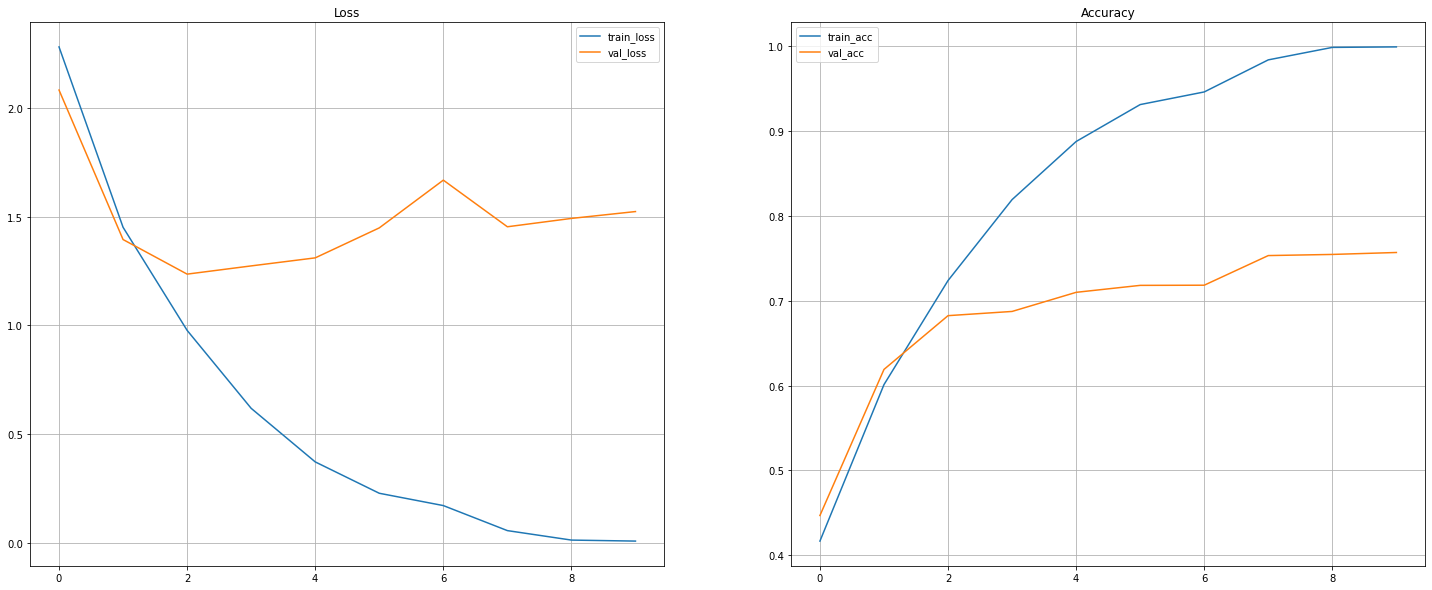

In [45]:
loss, acc, val_loss, val_acc = zip(*history)

show_acc_loss(loss, val_loss, acc, val_acc)

Видим, что наша сеть сильно переобучается, следовательно на новых данных она будет плохо обобщаться -> покажет невысокое качество.

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_cnn, test_loader)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Вычислим целевую метрику на валидационной выборке.

In [47]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn, imgs)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)

f1_score(actual_labels, y_pred, average='weighted')

0.7749579831932774

In [48]:
torch.cuda.empty_cache()

Посмотрим на сколько модель уверена в своих предсказаниях.

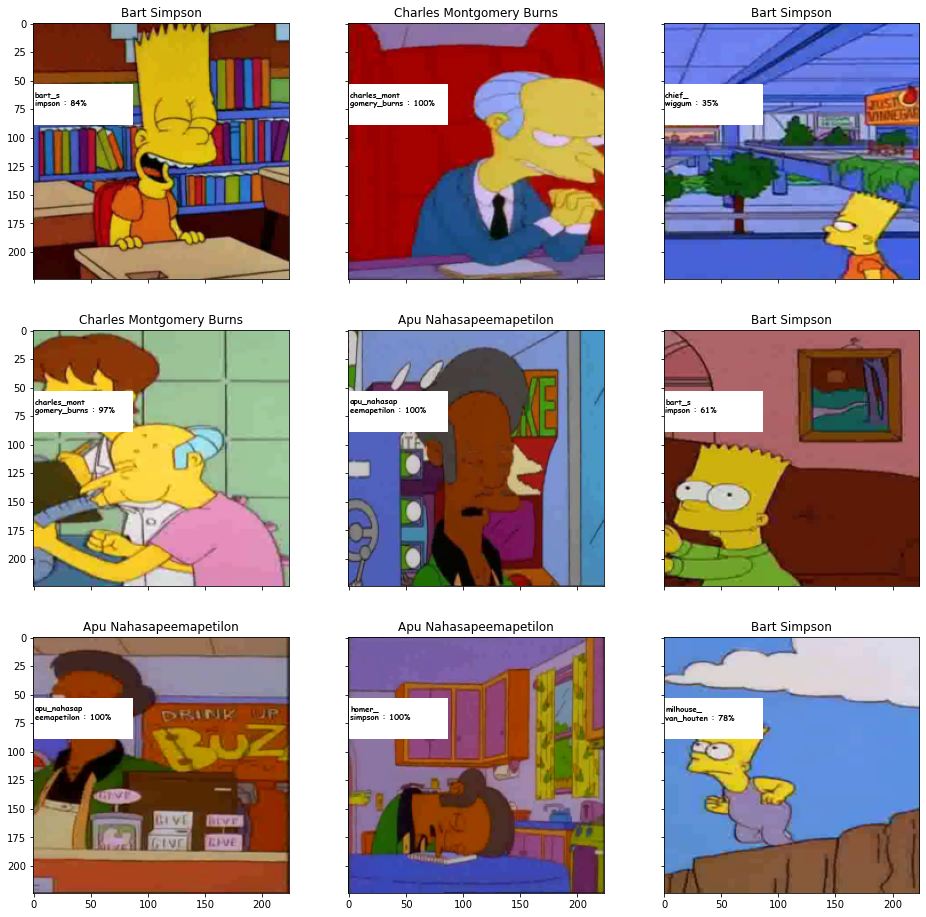

In [138]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [49]:
submission = pd.read_csv("./sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [50]:
submission.to_csv('my_cnn.csv', index=False)

**Результат на kaggle = 0.95217**

Получили достаточно неплохое качество, но попробуем его улучшить.

# Feature Extractor // VGG16

Попробуем использовать предобученную модель VGG16. Все веса модели оставим без изменений, а полносвязный слой, отвечающий за итоговую классификацию изменим под необходимое количество классов.

In [62]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [63]:
vgg16 = models.vgg16(pretrained=True)

In [64]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [65]:
for param in vgg16.parameters():
    param.requires_grad = False

In [66]:
num_features = 25088
n_classes = len(np.unique(train_val_labels))
vgg16.classifier = nn.Linear(num_features, n_classes)

vgg16.cuda()
optimizer = optim.AdamW(vgg16.parameters(), lr=1e-4, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [67]:
history = train(train_dataset, val_dataset, model=vgg16, epochs=10, batch_size=64,
                optimizer=optimizer, scheduler=scheduler)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 1.7317289600775374


epoch:  10%|███████▌                                                                   | 1/10 [02:48<25:16, 168.47s/it]


Epoch 001 train_loss: 1.7317     val_loss 1.1277 train_acc 0.5687 val_acc 0.7298
loss 0.5386361271452392


epoch:  20%|███████████████                                                            | 2/10 [05:36<22:25, 168.24s/it]


Epoch 002 train_loss: 0.5386     val_loss 0.9237 train_acc 0.8928 val_acc 0.7772
loss 0.27084712472392675


epoch:  30%|██████████████████████▌                                                    | 3/10 [08:22<19:31, 167.39s/it]


Epoch 003 train_loss: 0.2708     val_loss 0.8556 train_acc 0.9660 val_acc 0.7958
loss 0.1553276687973441


epoch:  40%|██████████████████████████████                                             | 4/10 [11:09<16:41, 166.97s/it]


Epoch 004 train_loss: 0.1553     val_loss 0.8315 train_acc 0.9904 val_acc 0.7958
loss 0.09731237249486506


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [13:55<13:53, 166.64s/it]


Epoch 005 train_loss: 0.0973     val_loss 0.8154 train_acc 0.9977 val_acc 0.8021
loss 0.06589789427942634


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [16:41<11:05, 166.48s/it]


Epoch 006 train_loss: 0.0659     val_loss 0.7982 train_acc 0.9994 val_acc 0.8070
loss 0.04747739034163298


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [19:27<08:19, 166.43s/it]


Epoch 007 train_loss: 0.0475     val_loss 0.8010 train_acc 0.9999 val_acc 0.8049
loss 0.0353339354715436


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [22:14<05:32, 166.38s/it]


Epoch 008 train_loss: 0.0353     val_loss 0.7972 train_acc 1.0000 val_acc 0.8061
loss 0.03438205823349253


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [25:00<02:46, 166.37s/it]


Epoch 009 train_loss: 0.0344     val_loss 0.7956 train_acc 1.0000 val_acc 0.8072
loss 0.033459487704723775


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [27:46<00:00, 166.67s/it]


Epoch 010 train_loss: 0.0335     val_loss 0.7958 train_acc 1.0000 val_acc 0.8074


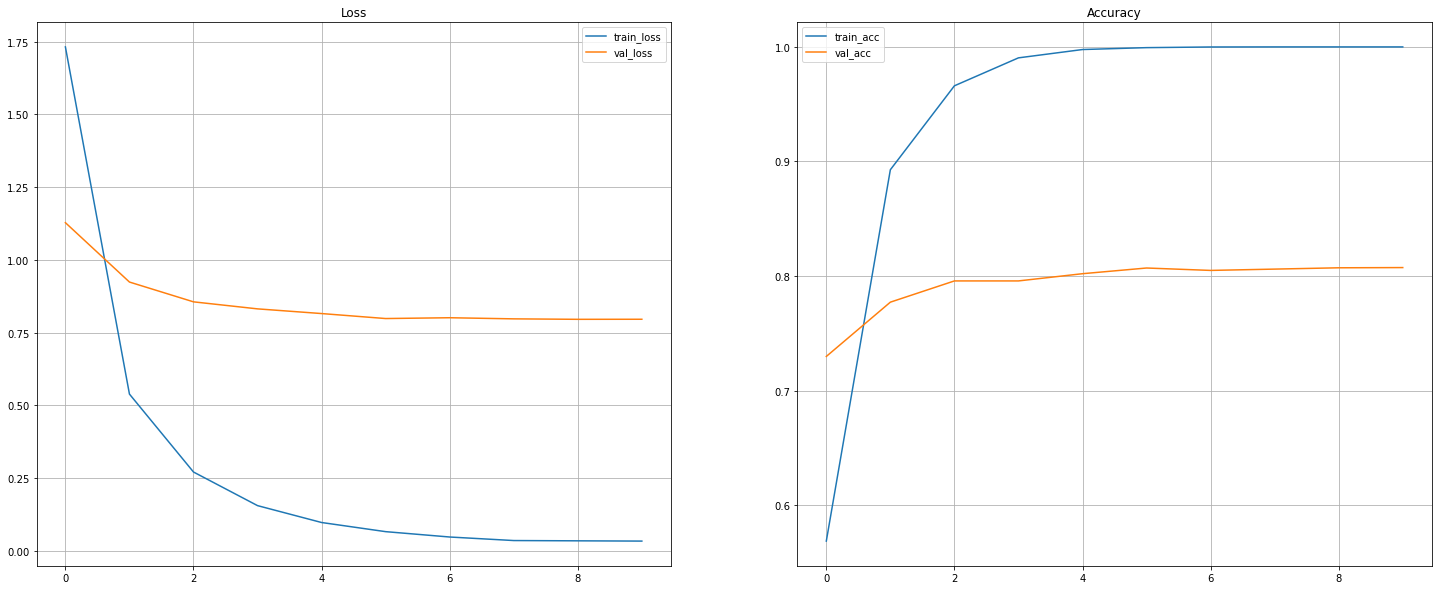

In [68]:
# визуализируем
loss, acc, val_loss, val_acc = zip(*history)
show_acc_loss(loss, val_loss, acc, val_acc)

In [69]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(vgg16, test_loader)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [70]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(vgg16, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(vgg16, imgs)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)

f1_score(actual_labels, y_pred, average='weighted')

0.7360606060606061

In [71]:
torch.cuda.empty_cache()

Посмотрим на сколько модель уверена в своих предсказаниях.

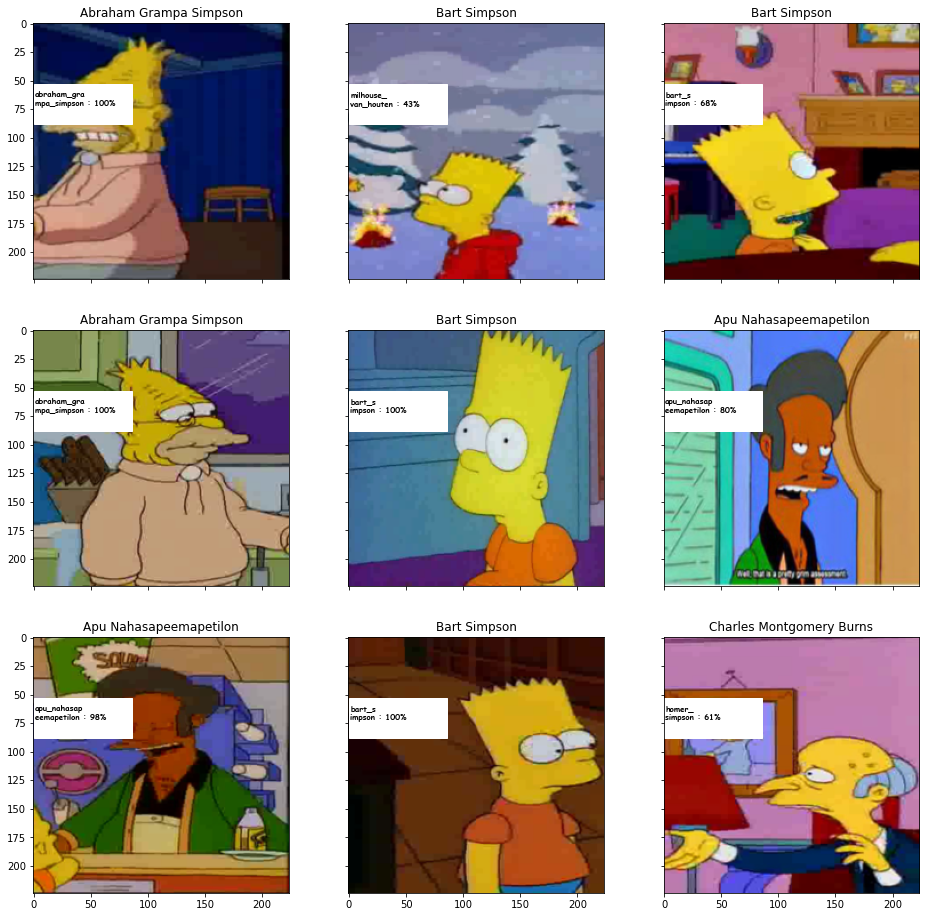

In [139]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg16, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [72]:
submission = pd.read_csv("./sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg           homer_simpson
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [73]:
submission.to_csv('vgg16.csv', index=False)

**Результат на kaggle = 0.87778**

# Feature Extractor // ResNet50

Аналогично попробуем использовать предобученную модель ResNet50. Все веса модели оставим без изменений, а полносвязный слой, отвечающий за итоговую классификацию изменим под необходимое количество классов.

In [51]:
ResNet50 = models.resnet50(pretrained=True)

In [2]:
#ResNet50

Видим, что на полносвязный слой приходят 2048 каналов. Изменим этот слой.

In [53]:
for param in ResNet50.parameters():
    param.requires_grad = False

In [54]:
num_features = 2048
n_classes = len(np.unique(train_val_labels))
ResNet50.fc = nn.Linear(num_features, n_classes)

ResNet50.cuda()
optimizer = optim.AdamW(ResNet50.parameters(), lr=1e-2, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [55]:
history = train(train_dataset, val_dataset, model=ResNet50, epochs=10, batch_size=64,
                optimizer=optimizer, scheduler=scheduler)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 2.705430414313852


epoch:  10%|███████▌                                                                   | 1/10 [02:02<18:18, 122.04s/it]


Epoch 001 train_loss: 2.7054     val_loss 1.7090 train_acc 0.5501 val_acc 0.6144
loss 1.2968674843019266


epoch:  20%|███████████████                                                            | 2/10 [04:00<16:01, 120.16s/it]


Epoch 002 train_loss: 1.2969     val_loss 1.5899 train_acc 0.7015 val_acc 0.6836
loss 1.1788774760382685


epoch:  30%|██████████████████████▌                                                    | 3/10 [05:58<13:54, 119.16s/it]


Epoch 003 train_loss: 1.1789     val_loss 1.5270 train_acc 0.7306 val_acc 0.6890
loss 1.1028975705917006


epoch:  40%|██████████████████████████████                                             | 4/10 [07:56<11:51, 118.60s/it]


Epoch 004 train_loss: 1.1029     val_loss 1.7298 train_acc 0.7509 val_acc 0.7000
loss 0.9993148112010026


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [09:54<09:51, 118.33s/it]


Epoch 005 train_loss: 0.9993     val_loss 1.6559 train_acc 0.7691 val_acc 0.7149
loss 0.9393562358085104


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [11:52<07:52, 118.08s/it]


Epoch 006 train_loss: 0.9394     val_loss 1.6698 train_acc 0.7864 val_acc 0.6985
loss 0.925316936605728


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [13:49<05:53, 117.91s/it]


Epoch 007 train_loss: 0.9253     val_loss 2.3025 train_acc 0.7899 val_acc 0.6708
loss 0.3977240791272734


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [15:47<03:55, 117.85s/it]


Epoch 008 train_loss: 0.3977     val_loss 1.0475 train_acc 0.8911 val_acc 0.7982
loss 0.3021770209326502


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [17:44<01:57, 117.77s/it]


Epoch 009 train_loss: 0.3022     val_loss 0.9992 train_acc 0.9118 val_acc 0.8009
loss 0.2814382762846366


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [19:42<00:00, 118.24s/it]


Epoch 010 train_loss: 0.2814     val_loss 0.9841 train_acc 0.9168 val_acc 0.8011


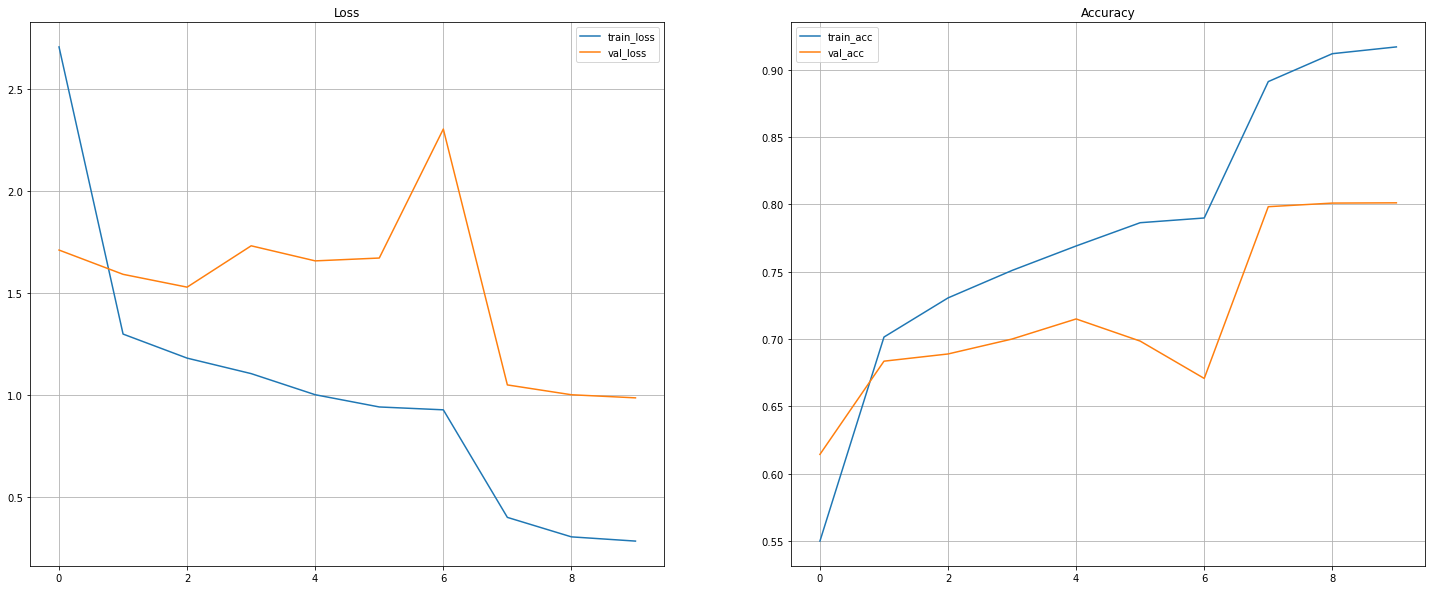

In [56]:
loss, acc, val_loss, val_acc = zip(*history)
show_acc_loss(loss, val_loss, acc, val_acc)

Сеть по-прежнему переобучается, посмотрим на метрику на валидационной выборке.

In [57]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(ResNet50, test_loader)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [58]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(ResNet50, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(ResNet50, imgs)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)

f1_score(actual_labels, y_pred, average='weighted')

0.7443589743589745

In [59]:
torch.cuda.empty_cache()

Посмотрим на сколько модель уверена в своих предсказаниях.

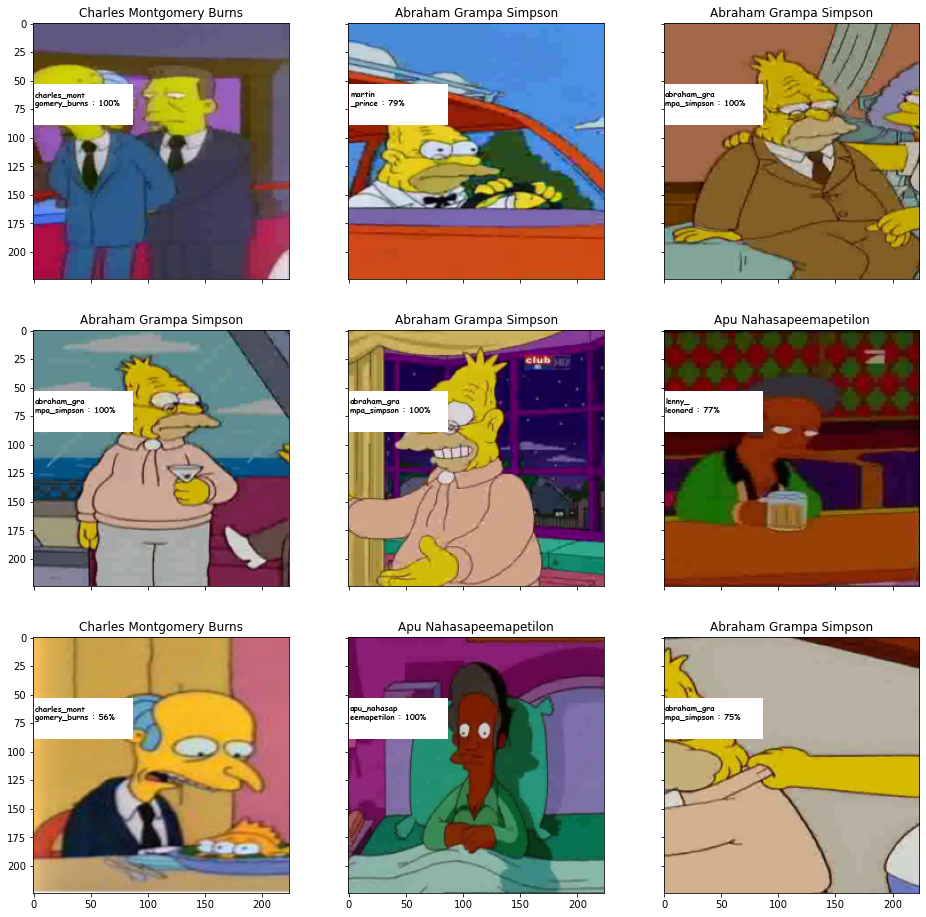

In [140]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(ResNet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [60]:
submission = pd.read_csv("./sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [61]:
submission.to_csv('ResNet50.csv', index=False)

**Результат на kaggle = 0.81152**

Можем заметить, что способ Feature Extractor для готовых моделей не позволяет достичь требуемого качества на нашем датасете. В следующем разделе попробуем применить Fine Tuning.

# Fine Tuning // EfficientNet // Augmentation

В отличие от предыдущих случаев, здесь возьмем предобученную модель и заново обучим все ее слои на наших данных. С целью добавления новых данных в датасет воспользуемся аугментациями. Для этого немного изменим класс `SimpsonsDataset`.

In [116]:
class SimpsonsDataset2(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры с аугментацией 
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('./label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        """
        Для обучающей и валидационной выборок используем свои преобразования
        """
        tranform = {
            
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=(-20,20)),          # добавили аугментацию поворота изображения
                transforms.RandomHorizontalFlip(),                    # добавили аугментацию зеркального отображения
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
            
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        }

        aug = (tranform['train'] if self.mode == 'train' else tranform['val_test']) 
        x = self.load_sample(self.files[index])
        x = aug(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [117]:
val_dataset = SimpsonsDataset2(val_files, mode='val')
train_dataset = SimpsonsDataset2(train_files, mode='train')

In [118]:
eff_net = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [119]:
for param in eff_net.parameters():
    param.requires_grad = True

In [1]:
#eff_net

In [121]:
n_classes = len(np.unique(train_val_labels))
num_features = 1408
eff_net._fc = nn.Linear(num_features, n_classes)

eff_net.cuda()
optimizer = optim.AdamW(eff_net.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [122]:
history = train(train_dataset, val_dataset, model=eff_net, epochs=20, batch_size=32,
                optimizer=optimizer, scheduler=scheduler, over_train=2)

epoch:   0%|                                                                                    | 0/20 [00:00<?, ?it/s]

loss 0.5617078148050212


epoch:   5%|███▋                                                                     | 1/20 [04:24<1:23:47, 264.58s/it]


Epoch 001 train_loss: 0.5617     val_loss 0.2854 train_acc 0.8621 val_acc 0.9259
loss 0.4200510687072973


epoch:  10%|███████▎                                                                 | 2/20 [08:44<1:18:31, 261.75s/it]


Epoch 002 train_loss: 0.4201     val_loss 0.2257 train_acc 0.8888 val_acc 0.9499
loss 0.20273088586790575


epoch:  15%|██████████▉                                                              | 3/20 [13:03<1:13:52, 260.73s/it]


Epoch 003 train_loss: 0.2027     val_loss 0.3200 train_acc 0.9474 val_acc 0.9255
loss 0.06860175436865674


epoch:  20%|██████████████▌                                                          | 4/20 [17:37<1:10:51, 265.73s/it]


Epoch 004 train_loss: 0.0686     val_loss 0.1251 train_acc 0.9820 val_acc 0.9750
loss 0.0375177190947343


epoch:  25%|██████████████████▎                                                      | 5/20 [22:00<1:06:12, 264.84s/it]


Epoch 005 train_loss: 0.0375     val_loss 0.1240 train_acc 0.9908 val_acc 0.9767
loss 0.026333209136279085


epoch:  30%|█████████████████████▉                                                   | 6/20 [26:19<1:01:18, 262.76s/it]


Epoch 006 train_loss: 0.0263     val_loss 0.1168 train_acc 0.9941 val_acc 0.9799
loss 0.01640309903254821


epoch:  35%|██████████████████████████▎                                                | 7/20 [30:37<56:37, 261.33s/it]


Epoch 007 train_loss: 0.0164     val_loss 0.1166 train_acc 0.9964 val_acc 0.9805
loss 0.014177576965431486


epoch:  40%|██████████████████████████████                                             | 8/20 [34:55<52:03, 260.33s/it]


Epoch 008 train_loss: 0.0142     val_loss 0.1186 train_acc 0.9967 val_acc 0.9811
loss 0.013395087885632486


epoch:  45%|█████████████████████████████████▊                                         | 9/20 [39:13<47:35, 259.61s/it]


Epoch 009 train_loss: 0.0134     val_loss 0.1211 train_acc 0.9973 val_acc 0.9809
loss 0.012096964158991906


epoch:  50%|█████████████████████████████████████                                     | 10/20 [43:33<43:33, 261.31s/it]


Epoch 010 train_loss: 0.0121     val_loss 0.1215 train_acc 0.9973 val_acc 0.9813


Обучение остановилось раньше, т.к. модель стала переобучаться.

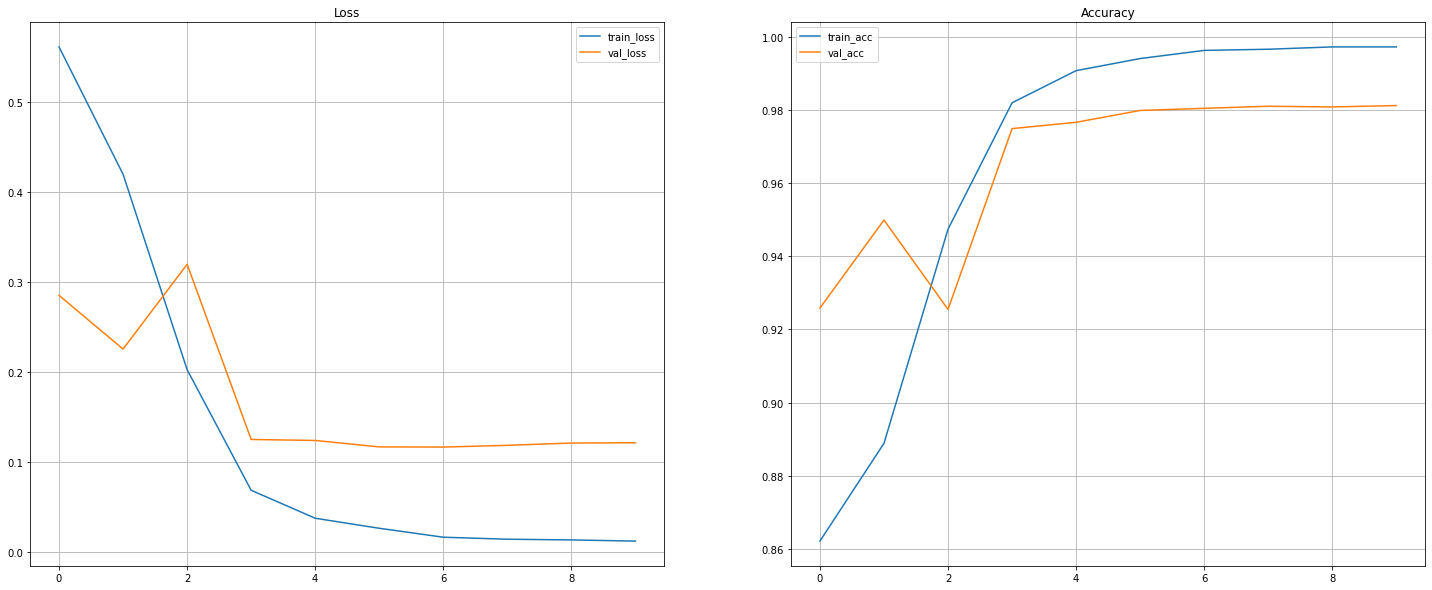

In [123]:
# визуализируем
loss, acc, val_loss, val_acc = zip(*history)
show_acc_loss(loss, val_loss, acc, val_acc)

In [124]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(eff_net, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(eff_net, imgs)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))

In [125]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[y_hat] for y_hat in y_pred]
label_encoder.transform(preds_class)
f1_score(actual_labels, preds_class, average='weighted')

0.9722222222222221

In [126]:
torch.cuda.empty_cache()

Посмотрим на сколько модель уверена в своих предсказаниях.

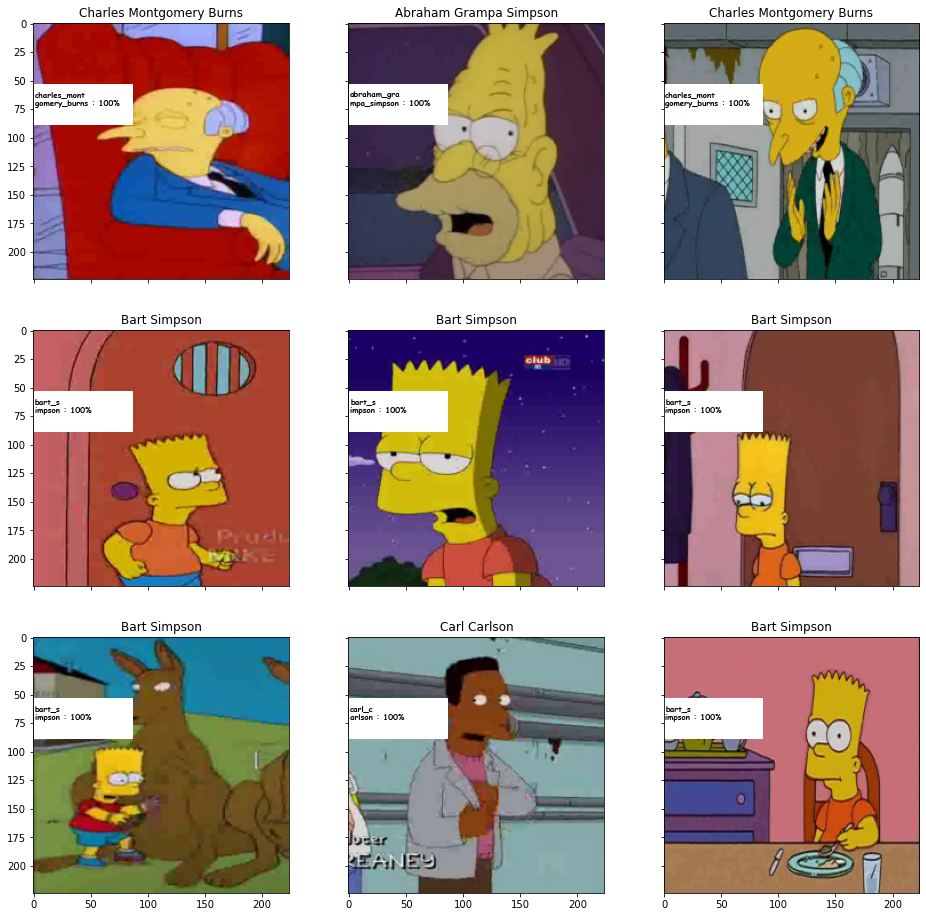

In [141]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(eff_net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [128]:
test_dataset = SimpsonsDataset2(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [129]:
probs = predict(eff_net, test_loader)

In [130]:
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [131]:
submission = pd.read_csv("./sample_submission.csv")
submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon

In [132]:
submission.to_csv('eff_net.csv', index=False)

**Результат на kaggle = 0.99681**

# Итоги

Сведем полученные результаты в таблицу.

In [144]:
final = pd.DataFrame({'model':['Своя сверточная сеть', 'VGG16 + FeatureExtractor', 'ResNet50 + FeatureExtractor', 'EfficientNet B2 + FineTuning + Augmentation'],
                     'result Kaggle':[0.95217, 0.87778, 0.81152, 0.99681]})

In [145]:
final

model  result Kaggle
0                         Своя сверточная сеть        0.95217
1                     VGG16 + FeatureExtractor        0.87778
2                  ResNet50 + FeatureExtractor        0.81152
3  EfficientNet B2 + FineTuning + Augmentation        0.99681

Основным заданием было обучить модель на основе сверточных сетей, чтобы классифицировать персонажей проживающих в Спрингфилде. Основная метрика - F1-score - необходимо получить свыше 0.83. Лучший результат достигли на модели `Fine Tuning // EfficientNet // Augmentation` - 0.99681